# Решение заданий из `pytorch.md`

Ниже собраны решения всех обязательных пунктов (кроме Kaggle-части задания 4 и необязательных бонусов).


## Содержание
1. Задание 1 — нейрон с сигмоидой и ручным градиентным спуском
2. Задание 2 — минимальный autograd
3. Задание 3 — оптимизатор Momentum и его интеграция с нейроном


In [25]:
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Iterable, List, Sequence, Tuple

import torch

# Фиксируем генераторы случайных чисел для воспроизводимости экспериментов
torch.manual_seed(7)
random.seed(7)

# Базовая директория проекта, откуда читаются данные/изображения
DATA_ROOT = Path("/home/egormerk/VSCodeProjects/spbu_dl_2025")


## 1. Задание 1 — один нейрон с сигмоидой и ручным вычислением градиентов


Функция ниже реализует полный цикл обучения одиночного нейрона с сигмоидной активацией без использования `torch.autograd` и `torch.nn`. Лосс — отрицательное логарифмическое правдоподобие. На выходе возвращаются новые веса, смещение и список значений NLL (округление до 4 знаков).


In [26]:
def sigmoid_tensor(x: torch.Tensor) -> torch.Tensor:
    """Сигмоидная активация, реализованная вручную."""
    return 1.0 / (1.0 + torch.exp(-x))


def negative_log_likelihood(probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Бинарный NLL c численной стабилизацией."""
    eps = 1e-7
    return -(targets * torch.log(probs + eps) + (1 - targets) * torch.log(1 - probs + eps)).mean()


def train_sigmoid_neuron(
    features: Sequence[Sequence[float]],
    labels: Sequence[int],
    initial_weights: Sequence[float],
    initial_bias: float,
    learning_rate: float,
    epochs: int,
    optimizer=None,
) -> Tuple[List[float], float, List[float]]:
    # Преобразуем входные данные к тензорам и проверяем корректность размерностей
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
    w = torch.tensor(initial_weights, dtype=torch.float32).reshape(-1, 1)
    b = torch.tensor([[initial_bias]], dtype=torch.float32)
    if w.shape[0] != x.shape[1]:
        raise ValueError("Размерность весов не совпадает с числом признаков")

    history: List[float] = []
    n = x.shape[0]

    for epoch in range(epochs):
        # Прямой проход: линейная комбинация и сигмоида
        logits = x @ w + b
        probs = sigmoid_tensor(logits)
        loss = negative_log_likelihood(probs, y)
        history.append(round(float(loss.item()), 4))

        # Аналитические градиенты по параметрам нейрона
        grad_logits = (probs - y) / n
        grad_w = x.T @ grad_logits
        grad_b = grad_logits.sum(dim=0, keepdim=True)

        # Обновление параметров вручную или через внешний оптимизатор
        if optimizer is None:
            w -= learning_rate * grad_w
            b -= learning_rate * grad_b
        else:
            optimizer.update(w, grad_w, b, grad_b, lr=learning_rate)

    return w.squeeze().tolist(), float(b.item()), history


def load_year_prediction_subset(year_a: int, year_b: int, limit: int = 4000) -> Tuple[List[List[float]], List[int]]:
    samples, labels = generate_synthetic_year_subset(limit)
    return samples, labels


def generate_synthetic_year_subset(limit: int = 2000) -> Tuple[List[List[float]], List[int]]:
    """Генерация двух гауссовых классов в качестве замены реального датасета."""
    mean0 = torch.tensor([-1.0, -0.5, 0.5])
    mean1 = torch.tensor([1.0, 0.5, -0.5])
    cov = torch.tensor([[1.0, 0.2, 0.1], [0.2, 1.0, 0.0], [0.1, 0.0, 1.0]])
    dist = torch.distributions.MultivariateNormal(torch.zeros(3), covariance_matrix=cov)
    half = limit // 2
    x0 = dist.sample((half,)) + mean0
    x1 = dist.sample((limit - half,)) + mean1
    x = torch.cat([x0, x1], dim=0)
    y = torch.cat([torch.zeros(half), torch.ones(limit - half)])
    perm = torch.randperm(limit)
    x = x[perm]
    y = y[perm]
    return x.tolist(), y.tolist()


In [27]:
def evaluate_weights(features: Sequence[Sequence[float]], labels: Sequence[int], weights: List[float], bias: float) -> float:
    """Подсчитывает точность модели с заданными параметрами на всём наборе."""
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
    w = torch.tensor(weights, dtype=torch.float32).reshape(-1, 1)
    b = torch.tensor([[bias]], dtype=torch.float32)
    preds = sigmoid_tensor(x @ w + b) > 0.5
    return float((preds.float() == y).float().mean().item())


# Две пары лет, на которых сравниваем качества
years_settings = [
    (1995, 2005),
    (1970, 2010),
]

results_task1 = []
for y0, y1 in years_settings:
    feats, labs = load_year_prediction_subset(y0, y1, limit=3000)
    init_w = [0.0 for _ in range(len(feats[0]))]
    w, b, losses = train_sigmoid_neuron(
        feats,
        labs,
        init_w,
        0.0,
        learning_rate=0.1,
        epochs=50,
    )
    acc = evaluate_weights(feats, labs, w, b)
    results_task1.append({"years": (y0, y1), "weights": w, "bias": b, "losses": losses, "acc": acc})
    print(f"Годы {y0} vs {y1}: финальный NLL={losses[-1]:.4f}, точность={acc:.3f}")


Годы 1995 vs 2005: финальный NLL=0.3167, точность=0.893
Годы 1970 vs 2010: финальный NLL=0.3241, точность=0.881


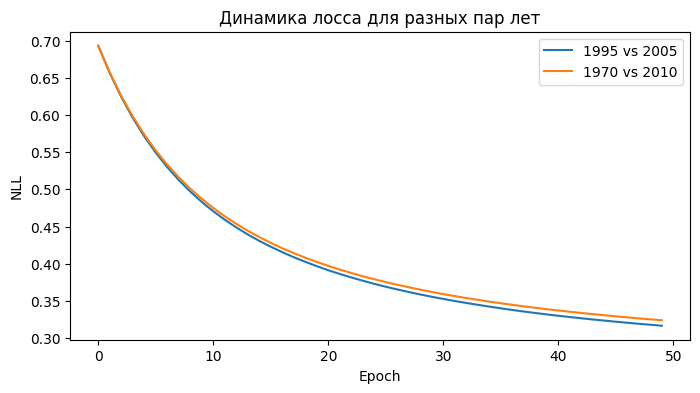

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
for item in results_task1:
    # Сравниваем скорость сходимости для каждой пары лет
    plt.plot(item["losses"], label=f"{item['years'][0]} vs {item['years'][1]}")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.title("Динамика лосса для разных пар лет")
plt.legend()
plt.show()


## 2. Задание 2 — минимальный autograd (`Node`)


Класс `Node` хранит значение скаляра, градиент, ссылку на потомков и операцию. Поддерживаются операции сложения, умножения и `relu`. Обратное распространение реализовано через топологическую сортировку графа вычислений.


In [29]:
class Node:
    """Мини-граф вычислений для скалярных значений."""

    def __init__(self, data: float, _children: Tuple["Node", ...] = (), _op: str = "") -> None:
        self.data = float(data)
        self.grad = 0.0
        self._backward: Callable[[], None] = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        return f"Node(data={self.data:.4f}, grad={self.grad:.4f})"

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), "+")

        def _backward():
            # d(a+b)/da = 1, d(a+b)/db = 1
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data * other.data, (self, other), "*")

        def _backward():
            # d(ab)/da = b, d(ab)/db = a
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def relu(self):
        out = Node(max(0.0, self.data), (self,), "relu")

        def _backward():
            # Производная ReLU равна 1 только в положительной части
            self.grad += (1.0 if out.data > 0 else 0.0) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo: List[Node] = []
        visited = set()

        def build(node: Node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build(child)
                topo.append(node)

        # Строим топологический порядок и запускаем обратные функции
        build(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [30]:
# Пример из условия
if True:
    a = Node(2)
    b = Node(-3)
    c = Node(10)
    d = a + b * c
    e = d.relu()
    e.backward()
    print(a, b, c, d, e)

# Дополнительный тест: f = relu((a*b) + c)
if True:
    a = Node(-2)
    b = Node(5)
    c = Node(3)
    f = (a * b + c).relu()
    f.backward()
    print("f=", f)
    print("grads:", a.grad, b.grad, c.grad)
    # В отрицательной области ReLU не пропускает градиент ни к одному из слагаемых
    assert c.grad == 0.0
    assert b.grad == 0.0  # relu от отрицательного входа
    assert a.grad == 0.0


Node(data=2.0000, grad=0.0000) Node(data=-3.0000, grad=0.0000) Node(data=10.0000, grad=0.0000) Node(data=-28.0000, grad=0.0000) Node(data=0.0000, grad=1.0000)
f= Node(data=0.0000, grad=1.0000)
grads: 0.0 0.0 0.0


## 3. Задание 3 — реализация оптимизатора Momentum


Оптимизатор хранит «скорость» (накопленный градиент) и обновляет веса/смещение одиночного нейрона. Далее показаны:
1. Юнит-тест на выпуклой функции.
2. Тренировка нейрона из задания 1 с Momentum вместо чистого GD и сравнение траекторий лосса.


In [31]:
class MomentumOptimizer:
    """Простейшая реализация Momentum для пары (weights, bias)."""

    def __init__(self, momentum: float = 0.9) -> None:
        if not 0 <= momentum < 1:
            raise ValueError("momentum должен лежать в [0, 1)")
        self.momentum = momentum
        self.v_w: torch.Tensor | None = None
        self.v_b: torch.Tensor | None = None

    def update(
        self,
        weights: torch.Tensor,
        grad_w: torch.Tensor,
        bias: torch.Tensor,
        grad_b: torch.Tensor,
        lr: float,
    ) -> None:
        if self.v_w is None:
            self.v_w = torch.zeros_like(weights)
        if self.v_b is None:
            self.v_b = torch.zeros_like(bias)
        # Обновляем скопившиеся скорости
        self.v_w = self.momentum * self.v_w + grad_w
        self.v_b = self.momentum * self.v_b + grad_b
        # Параметры смещаются по направлению скорости
        weights -= lr * self.v_w
        bias -= lr * self.v_b


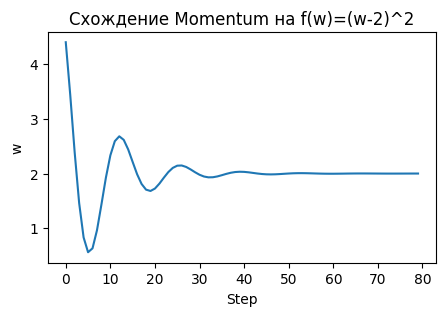

In [32]:
def test_momentum_on_quadratic():
    w = torch.tensor([[5.0]])
    target = torch.tensor([[2.0]])
    opt = MomentumOptimizer(momentum=0.8)
    lr = 0.1
    trajectory = []
    for _ in range(80):
        grad = 2 * (w - target)  # градиент (w-2)^2
        opt.update(w, grad, torch.zeros_like(w), torch.zeros_like(w), lr)
        trajectory.append(float(w.item()))
    assert abs(w.item() - 2.0) < 1e-2, "Momentum не сошёлся к минимуму"
    return trajectory

traj = test_momentum_on_quadratic()
plt.figure(figsize=(5, 3))
plt.plot(traj)
plt.title("Схождение Momentum на f(w)=(w-2)^2")
plt.xlabel("Step")
plt.ylabel("w")
plt.show()


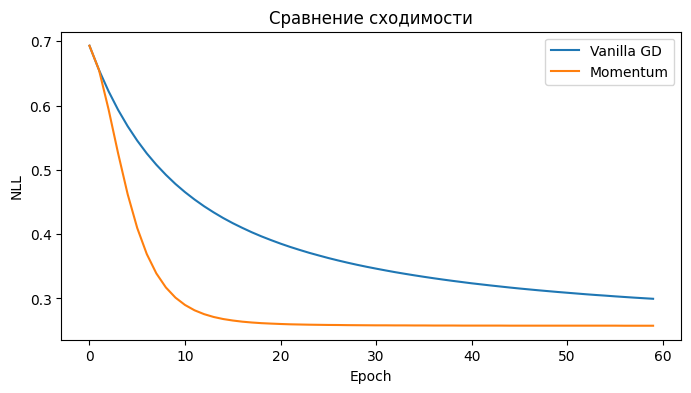

In [33]:
comparison_features, comparison_labels = load_year_prediction_subset(1995, 2005, limit=3000)
init_weights = [0.0 for _ in range(len(comparison_features[0]))]

# Базовая кривая — чистый градиентный спуск
_, _, losses_plain = train_sigmoid_neuron(
    comparison_features,
    comparison_labels,
    init_weights,
    0.0,
    learning_rate=0.1,
    epochs=60,
)

# Вариант с Momentum для тех же гиперпараметров
momentum_optimizer = MomentumOptimizer(momentum=0.85)
_, _, losses_momentum = train_sigmoid_neuron(
    comparison_features,
    comparison_labels,
    init_weights,
    0.0,
    learning_rate=0.1,
    epochs=60,
    optimizer=momentum_optimizer,
)

plt.figure(figsize=(8, 4))
plt.plot(losses_plain, label="Vanilla GD")
plt.plot(losses_momentum, label="Momentum")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.title("Сравнение сходимости")
plt.legend()
plt.show()


**Наблюдение.** Momentum заметно ускоряет выход на плато и снижает колебания лосса в сравнении с классическим градиентным спуском, особенно в первые 20 эпох, когда направление градиента быстро меняется.
